In [1]:
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
import pickle
from torchmetrics import StructuralSimilarityIndexMeasure
from statistics import median, mean
from matplotlib import pyplot as plt
import numpy as np
from pytorch_msssim import ssim, ms_ssim, SSIM, MS_SSIM
from torchsummary import summary
import json
from tqdm import tqdm
from glob import glob
import sys
path = "/study3/mrphys/skunkworks/kk/mriUnet"
sys.path.insert(0,path)
import unet
from torchvision import transforms
from torch.utils.data import Dataset
import h5py
from sklearn.model_selection import KFold as kf
import os
import nibabel as nib

T1path = sorted(glob('/study3/mrphys/skunkworks/training_data/mover01/*/processed_data/T1_3_tv.nii'))
xPath = sorted(glob('/scratch/mrphys/denoised/denoised_*.h5'))
gtPath = sorted(glob('/study3/mrphys/skunkworks/training_data/mover01/*/processed_data/C.h5'))

def slice2d(array, discardZero=False):
    '''
    slice a 4d array of shape (c-channel, n, n, n) where n in the cube length
    into 3d arrays slices of shape (c, n, n) per each 2d plane
    '''
    result = []
    c, w, h, d = array.shape
    assert (w==h)and(h==d)and(d==w), f"Array must be cubic, got: {w}x{h}x{d}"
    for i in range(w):
        result.append(array[:,i,:,:])
        result.append(array[:,:,i,:])
        result.append(array[:,:,:,i])
    return np.array(result)

def getComplexSlices(path, return_scale=False):

    with h5py.File(path,'r') as hf:
        prefix = 'C_000_0'
        imagestackReal = []
        imagestackImag = []
        for i in range(6):
            n = prefix + str(i).zfill(2)
            image = hf['Images'][n]
            imagestackReal.append(np.array(image['real']))
            imagestackImag.append(np.array(image['imag']))
            if i==0:
                normScale = np.max([np.abs(np.array(image['real'])).max(), np.abs(np.array(image['imag'])).max()])
        imagestackReal = np.array(imagestackReal)/normScale
        imagestackImag = np.array(imagestackImag)/normScale
        imagesliceReal = slice2d(imagestackReal)
        imagesliceImag = slice2d(imagestackImag)
        
    if return_scale:
        return imagesliceReal+imagesliceImag*1j, normScale
    else:
        return imagesliceReal+imagesliceImag*1j
    
class T1Dataset(Dataset):
    
    def __init__(self, index, gt=False, norm_factor=1000):
    
        if gt:
            self.x_path = gtPath[index]
        else:
            self.x_path = xPath[index]  
        self.y_path = T1path[index]
        
        self.x = list(getComplexSlices(self.x_path))
        self.y = list(slice2d(np.transpose(nib.load(self.y_path).get_fdata()).reshape(1,256,256,256)/norm_factor))

    def __getitem__(self, index):
        return self.x[index], self.y[index]

    def __len__(self):
        return len(self.x)

In [11]:
np.mean(((y-np.average(y))**2))

0.4376754466353998

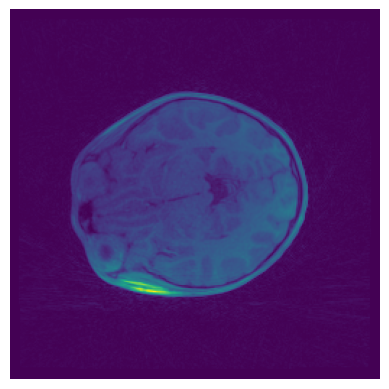

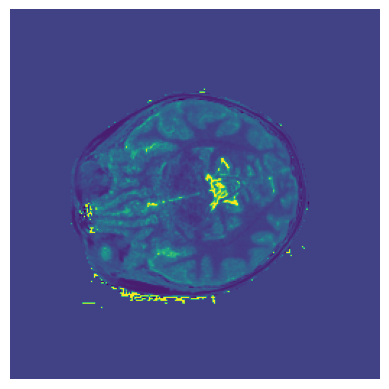

In [16]:
dataset = T1Dataset(10, gt=True)
x,y = dataset[360]
plt.axis('off')
plt.imshow(np.abs(x[0]))
plt.show()
plt.axis('off')
plt.imshow(np.abs(y[0]))
plt.show()

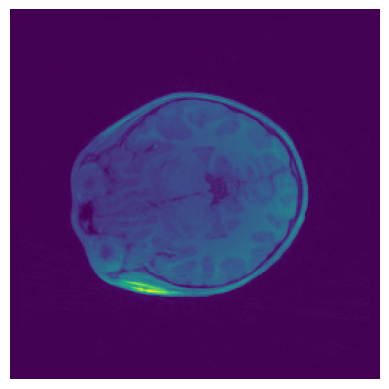

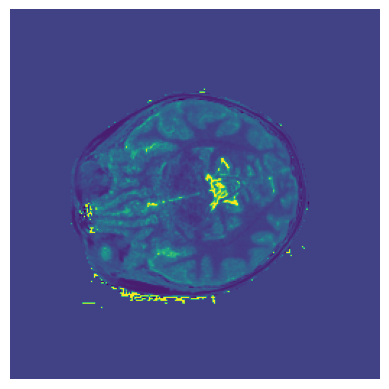

In [17]:
dataset = T1Dataset(10, gt=False)
x,y = dataset[360]
plt.axis('off')
plt.imshow(np.abs(x[0]))
plt.show()
plt.axis('off')
plt.imshow(np.abs(y[0]))
plt.show()

In [3]:
loader = DataLoader(dataset=dataset, batch_size=16, shuffle=True)

In [5]:
for X, y in loader:
    break
model = unet.UNet(6,
            1,
            f_maps=32,
            layer_order=['separable convolution', 'relu'],
            depth=3,
            layer_growth=2.0,
            residual=True,
            complex_input=True,
            complex_kernel=True,
            ndims=2,
            padding=1)

Crop amount [(-4, -4, -4, -4), (-16, -16, -16, -16)]


In [11]:
model = model.cuda()
X = X.cuda()
pred = model(X)

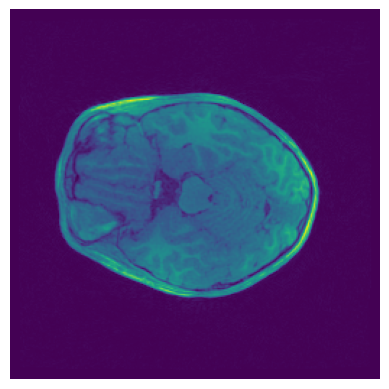

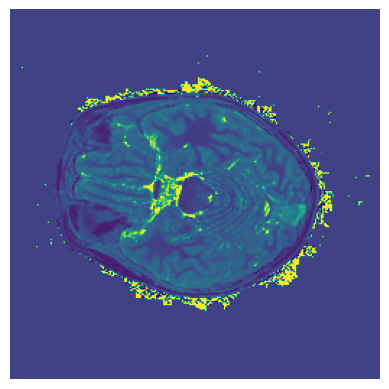

In [99]:
dataset2 = T1Dataset(0, gt=False)
x,y = dataset2[360]
plt.axis('off')
plt.imshow(np.abs(x[0]))
plt.show()
plt.axis('off')
plt.imshow(np.abs(y[0]))
plt.show()

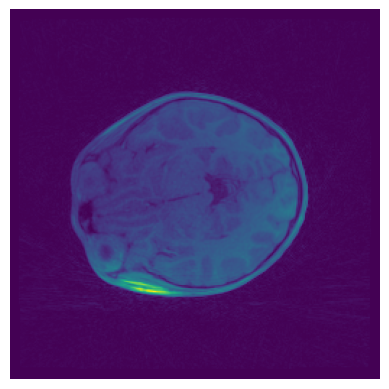

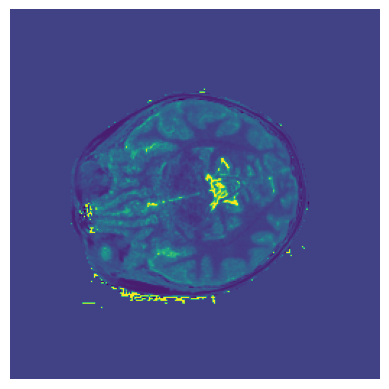

In [12]:
with open(f'/scratch/mrphys/pickled/T1dataset_{10}.pickle', 'rb') as f:
    dataset = pickle.load(f)
x,y = dataset[360]
plt.axis('off')
plt.imshow(np.abs(x[0]))
plt.show()
plt.axis('off')
plt.imshow(np.abs(y[0]))
plt.show()

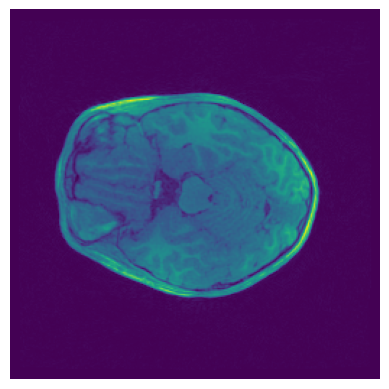

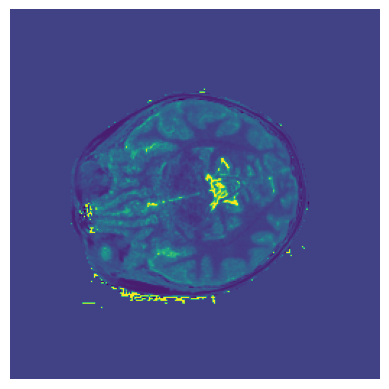

In [13]:
with open(f'/scratch/mrphys/pickled/T1dataset2_{10}.pickle', 'rb') as f:
    dataset = pickle.load(f)
x,y = dataset[360]
plt.axis('off')
plt.imshow(np.abs(x[0]))
plt.show()
plt.axis('off')
plt.imshow(np.abs(y[0]))
plt.show()